<center>
    <h1> ILI285 - Computación Científica I  / INF285 - Computación Científica </h1>
    <h2> Polynomial Interpolation: Vandermonde, Lagrange, Newton, Chebyshev </h2>
    <h2> [[S]cientific [C]omputing [T]eam](#acknowledgements)</h2>
    <h2> Version: 1.24</h2>
</center>

## Table of Contents
* [Introduction](#intro)
* [Vandermonde Matrix](#vander)
* [Lagrange Interpolation](#lagrange)
* [Runge Phenomenon](#runge)
* [Newton's Divided Difference](#DDN)
* [Interpolation Error](#Error)
* [Chebyshev Interpolation](#cheby)
* [Python Modules and Functions](#py)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from functools import reduce
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
%matplotlib inline
from ipywidgets import interact, fixed

<div id='intro' />
## Introduction

Hello! In this notebook we will learn how to interpolate 1D data with polynomials. A polynomial interpolation consists in finding a polynomial that fits a discrete set of known data points, allowing us to construct new data points within the range of the data. Formally, a polynomial $P(x)$ interpolate the data $(x_1,y_1),...,(x_n,y_n)$ if $P(x_i)=y_i$ for all $i$ in $1,...,n$. 

In [22]:
def Y(D, xi):
    # Function that evaluates the xi's points in the polynomial
    if D['M']=='Vandermonde':
        P = lambda i: i**np.arange(len(D['P']))
    elif D['M']=='Lagrange':
        P = lambda i: [np.prod(i - np.delete(D['x'],j)) for j in range(len(D['x']))]
    elif D['M']=='Newton':
        P = lambda i: np.append([1],[np.prod(i-D['x'][:j]) for j in range(1,len(D['P']))])
    return [np.dot(D['P'], P(i)) for i in xi]    
    
def Interpolation_Plot(D):
    # Function that shows the data points and the function that interpolates them.
    xi = np.linspace(min(D['x']),max(D['x']),100)
    yi = Y(D,xi)
    plt.figure(figsize=(8,8))
    plt.plot(D['x'],D['y'],'ro',label='Interpolation points')
    plt.plot(xi,yi,'b-',label='$P(x)$')
    plt.xlim(min(xi)-0.5, max(xi)+0.5)
    plt.ylim(min(yi)-0.5, max(yi)+0.5)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('$x$')
    #plt.ylabel('$P(x)$')
    plt.show()

<div id='vander' />
## Vandermonde Matrix

First, we are going to learn the Vandermonde Matrix method. This is a $m \times m$ matrix (with $m$ being the length of the set of known data points) with the terms of a geometric progression in each row. It allows us to construct a system of linear equations with the objective of find the coefficients of the polynomial function that interpolates our data.

Example:

Given the set of known data points: $(x_1,y_1),(x_2,y_2),(x_3,y_3)$ 

Our system of linear equations will be:

$$ \begin{bmatrix}
    1 & x_1 & x_1^2  \\[0.3em]
    1 & x_2 & x_2^2  \\[0.3em]
    1 & x_3 & x_3^2  \end{bmatrix}
    \begin{bmatrix}
    a_1  \\[0.3em]
    a_2  \\[0.3em]
    a_3  \end{bmatrix} =
    \begin{bmatrix}
    y_1  \\[0.3em]
    y_2  \\[0.3em]
    y_3  \end{bmatrix}$$ 
    
And solving it we will find the coefficients $a_1,a_2,a_3$ that we need to construct the polynomial $P(x)=a_1+a_2x+a_3x^2$ that interpolates our data.

In [3]:
def Vandermonde(x, y, show=False):
    # We construct the matrix and solve the system of linear equations
    A = np.array([xi**np.arange(len(x)) for xi in x])
    b = y
    xsol = np.linalg.solve(A,b)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
        print('A = '); print(np.array_str(A, precision=2, suppress_small=True))
        print("cond(A) = "+str(np.linalg.cond(A)))
        print('b = '); print(np.array_str(b, precision=2, suppress_small=True))
        print('x = '); print(np.array_str(xsol, precision=2, suppress_small=True))
        xS = sp.Symbol('x')
        F = np.dot(xS**np.arange(len(x)),xsol)
        print('Interpolation Function: ') 
        print('F(x) = ')
        print(F)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Vandermonde',
         'P':xsol,
         'x':x,
         'y':y}
    return D

In [4]:
def show_time_V(epsilon=0):
    x = np.array([1.0,2.0,3.0+epsilon,5.0,6.5])
    y = np.array([2.0,5.0,4.0,6.0,2.0])
    D = Vandermonde(x,y,True)
    Interpolation_Plot(D)
interact(show_time_V,epsilon=(-1,2,0.1))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=2.0, min=-1.0), Output()), _dom_classe…

<function __main__.show_time_V>

<div id='lagrange' />
## Lagrange Interpolation

With this method, we can interpolate data thanks to the Lagrange basis polynomials. Given a set of $n$ data points $(x_1,y_1),...,(x_n,y_n)$, the Lagrange interpolation polynomial is the following:

$$ P(x) = \sum^n_{i=1} y_i\,L_i(x),$$
    
where $L_i(x)$ are the Lagrange basis polynomials:

$$ L_i(x) = \prod^n_{j=1,j \neq i} \frac{x-x_j}{x_i-x_j} = \frac{x-x_1}{x_i-x_1} \cdot ... \cdot \frac{x-x_{i-1}}{x_i-x_{i-1}} \cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdot ... \cdot \frac{x-x_n}{x_i-x_n}$$

or simply $L_i(x)=\dfrac{l_i(x)}{l_i(x_i)}$, where $l_i(x)=\displaystyle{\prod^n_{j=1,j \neq i} (x-x_j)}$.

The most important property of these basis polynomials is: 

$$ L_{j \neq i}(x_i) = 0 $$

$$ L_i(x_i) = 1 $$

So, we assure that $L(x_i) = y_i$, which indeed interpolates the data.

In [5]:
def Lagrange(x, y, show=False):
    # We calculate the li's 
    p = np.array([y[i]/np.prod(x[i] - np.delete(x,i)) for i in range(len(x))])
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
        xS = sp.Symbol('x')
        L = np.dot(np.array([np.prod(xS - np.delete(x,i))/np.prod(x[i] - np.delete(x,i)) for i in range(len(x))]),y)
        print('Interpolation Function: '); 
        print(L)
        
    # Finally, we return a data structure with our interpolating polynomial        
    D = {'M':'Lagrange',
         'P':p,
         'x':x,
         'y':y}
    return D

In [6]:
def show_time_L(epsilon=0):
    x = np.array([1.0,2.0,3.0+epsilon,4.0,5.0,6.0,7.0])
    y = np.array([2.0,5.0,4.0,6.0,7.0,8.0,3.0])
    D = Lagrange(x,y,True)
    Interpolation_Plot(D)
interact(show_time_L,epsilon=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, min=-1.0), Output()), _dom_classe…

<function __main__.show_time_L>

Here you get some questions about Lagrange Interpolation:
- Explain what happens with the interpolator polynomial when you add a new point to the set of points to interpolate. **Answer: We need to recalculate the polynomial**
- Why it is not a good idea to use Lagrange interpolation for a set of points which is constantly changing? **A: Because we need to compute the whole interpolation again**
- What is the operation count of obtaining the interpolator polynomial using Lagrange? What happens with the error?

<div id='DDN' />
## Newton's Divided Difference

In this interpolation method we will use divided differences to calculate the coefficients of our interpolation polynomial. Given a set of $n$ data points $(x_1,y_1),...,(x_n,y_n)$, the Newton polynomial is:

$$ P(x) = \sum^n_{i=1} (f[x_1 ... x_i] \cdot \prod^{i-1}_{j=1} (x-x_j)) ,$$

where $ \prod^{0}_{j=1} (x-x_j) = 0 $, and:

$$ f[x_i] = y_i $$ 

$$ f[x_j...x_i] = \frac{f[x_{j+1}...x_i]-f[x_j...x_{i-1}]}{x_i-x_j}$$

In [7]:
def Divided_Differences(x, y):
    dd = np.array([y])
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
    return np.array(dd)
    
def Newton(x, y, show=False):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(len(x))])
        xS = sp.Symbol('x')
        N = np.dot(dd[:,0],np.append([1],[np.prod(xS-x[:i]) for i in range(1,len(dd))]))
        print('Interpolation Function: ');
        print(N)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y}
    return D

In [8]:
def show_time_N(epsilon=0):
    x = np.array([0.0,2.0,3.0+epsilon,4.0,5.0,6.0])
    y = np.array([1.0,3.0,0.0,6.0,8.0,4.0])
    D = Newton(x,y,True)
    Interpolation_Plot(D)
interact(show_time_N,epsilon=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, min=-1.0), Output()), _dom_classe…

<function __main__.show_time_N>

Questions about Newton's DD:
- What is the main problem using this method (and Lagrange)? How can you fix it? **A: A problem with polynomial interpolation with equispaced date is the Runge phenomenon and can be handle with Chebyshev points**
- What to do when a new point is added? **A: Pro, is not necessary re-calculate the whole polynomial only a small piece**

<div id='Error' />
## Polynomial Interpolation Error

The interpolation error is given by:

$$ f(x)-P(x) = \frac{(x-x_1) \cdot (x-x_2) \cdot ... \cdot (x-x_n)}{n!} \cdot f^{(n)}(c) ,$$

where $c$ is within the interval from the minimun value of $x$ and the maximum one.

In [9]:
def Error(f, n, xmin, xmax, method=Lagrange, points=np.linspace, plot_flag=True):
    # This function plots f(x), the interpolating polynomial, and the associated error
    # points can be np.linspace to equidistant points or Chebyshev to get Chebyshev points
    x = points(xmin,xmax,n)
    y = f(x)
    
    xe = np.linspace(xmin,xmax,100)
    ye = f(xe)
    
    D = method(x,y)
    yi = Y(D, xe)
    
    if plot_flag:
        plt.figure(figsize=(5,10))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = False)

        ax1.plot(xe, ye,'r-', label='f(x)')
        ax1.plot(x, y,'ro', label='Interpolation points')
        ax1.plot(xe, yi,'b-', label='Interpolation')
        ax1.set_xlim(xmin-0.5,xmax+0.5)
        ax1.set_ylim(min(yi)-0.5,max(yi)+0.5)       
        ax1.set_title('Interpolation')
        ax1.grid(True)
        ax1.set_xlabel('$x$')
        ax1.legend(loc='best') 

        ax2.semilogy(xe, abs(ye-yi),'b-', label='Absolute Error')
        ax2.set_xlim(xmin-0.5,xmax+0.5)
        ax2.set_title('Absolute Error')
        ax2.set_xlabel('$x$')
        ax2.grid(True)
        #ax2.legend(loc='best') 
        plt.show()
        
    return max(abs(ye-yi))

In [10]:
def test_error_Newton(n=5):
    #me = Error(lambda x: np.sin(x)**3, n, 1, 7, Newton)
    me = Error(lambda x: (1/(1+12*x**2)), n, -1, 1, Newton)
    print("Max Error:", me)

In [11]:
interact(test_error_Newton,n=(5,25))

interactive(children=(IntSlider(value=5, description='n', max=25, min=5), Output()), _dom_classes=('widget-int…

<function __main__.test_error_Newton>

<div id='runge' />
##  **Runge's Phenomenon**: It is a problem of oscillation of polynomials at the edges of the interval. 

We are interpolating a data that is 0 almost everywhere and 1 at the middle point, notice that when $n$ increases the oscilations increase and the red dots seems to be at 0 everywhere but it is just an artifact, there must be a 1 at the middle. The oscillations you see at the end of the interval is the Runge phenomenon. 

In [12]:
def Runge(n=9):
    x = np.linspace(0,1,n)
    y = np.zeros(n)
    y[int((n-1.0)/2.)]=1
    D = Newton(x,y,False)
    Interpolation_Plot(D)
interact(Runge,n=(5,25,2))

interactive(children=(IntSlider(value=9, description='n', max=25, min=5, step=2), Output()), _dom_classes=('wi…

<function __main__.Runge>

<div id='cheby' />
## Chebyshev Interpolation

With the objective of reducing the error of the polynomial interpolation, we need to find the values of $x_1,x_2,...,x_n$ that minimize $(x-x_1) \cdot (x-x_2) \cdot ... \cdot (x-x_n)$.

To choose these values of $-1 \leq x_1,x_2,...,x_n \leq 1$ (to use another interval we just need to do a change of variables) that minimize the error, we will use the roots of the Chebyshev polynomials, also called **Chebyshev nodes**, which are defined by:

$$ x_i = \cos\left(\frac{(2i-1)\pi}{2n}\right), i = 1,...,n $$

In [13]:
def Chebyshev(xmin,xmax,n=5):
    # This function calculates the n Chebyshev points and plots or returns them depending on ax
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    y = np.sin((2*ns-1)*np.pi/(2*n))
    plt.figure(figsize=(10,5))
    plt.ylim(-0.1,1.1)
    plt.xlim(-1.1,1.1)
    plt.plot(np.cos(np.linspace(0,np.pi)),np.sin(np.linspace(0,np.pi)),'k-')
    plt.plot([-2,2],[0,0],'k-')
    plt.plot([0,0],[-1,2],'k-')
    for i in range(len(y)):
        plt.plot([x[i],x[i]],[0,y[i]],'r-')
        plt.plot([0,x[i]],[0,y[i]],'r-')
    plt.plot(x,[0]*len(x),'bo',label='Chebyshev points')
    plt.plot(x,y,'ro')
    plt.xlabel('$x$')
    plt.title('n = '+str(n))
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()
def Chebyshev_points(xmin,xmax,n):
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    y = np.sin((2*ns-1)*np.pi/(2*n))
    return (xmin+xmax)/2 + (xmax-xmin)*x/2

In [14]:
interact(Chebyshev,xmin=fixed(-1),xmax=fixed(1),n=(2,50))

interactive(children=(IntSlider(value=5, description='n', max=50, min=2), Output()), _dom_classes=('widget-int…

<function __main__.Chebyshev>

By using these points, we reduce the numerator of the interpolation error formula:

$$ (x-x_1) \cdot (x-x_2) \cdot ... \cdot (x-x_n) = \dfrac{1}{2^{n-1}} \cdot T_n(x), $$

where $T(x) = \cos (n \cdot \arccos (x))$ is the n-th Chebyshev polynomial.

$$ T_0(x) = 1 $$
$$ T_1(x) = x $$
$$ T_2(x) = 2x^2 -1 $$
$$...$$
$$ T_{n+1}(x) = 2 \cdot x \cdot T_n(x) - T_{n-1}(x) $$

In [15]:
def T(n,x):
    # Recursive function that returns the n-th Chebyshev polynomial evaluated at x
    if n == 0:
        return x**0
    elif n == 1:
        return x
    else:
        return 2*x*T(n-1,x)-T(n-2,x)
    
def Chebyshev_Polynomials(n=2, Flag_All_Tn=False):
    # This function plots the first n Chebyshev polynomials
    x = np.linspace(-1,1,1000)
    plt.figure(figsize=(10,5))
    plt.xlim(-1, 1)
    plt.ylim(-1.1, 1.1)
    if Flag_All_Tn:
        for i in np.arange(n+1):
            y = T(i,x)
            plt.plot(x,y,label='$T_{'+str(i)+'}(x)$')
    else:
        y = T(n,x)
        plt.plot(x,y,label='$T_{'+str(n)+'}(x)$')
    #    plt.title('$T_${:}$(x)$'.format(n))
    plt.legend(loc='right')
    plt.grid(True)
    plt.xlabel('$x$')
    plt.show()

In [16]:
#Chebyshev_Polynomials(3,True)
interact(Chebyshev_Polynomials,n=(0,12),Flag_All_Tn=True)

interactive(children=(IntSlider(value=2, description='n', max=12), Checkbox(value=True, description='Flag_All_…

<function __main__.Chebyshev_Polynomials>

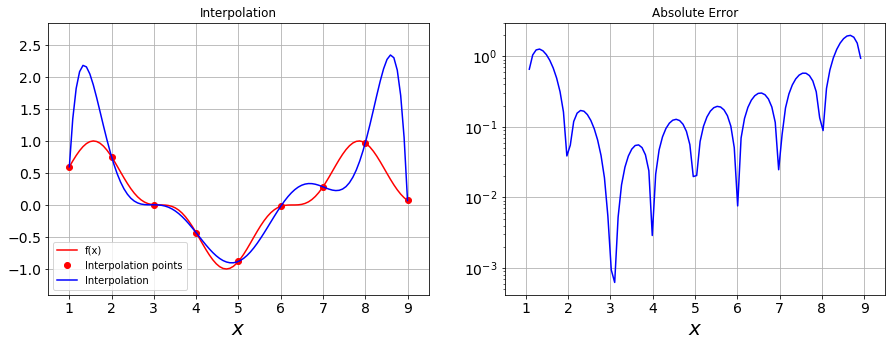

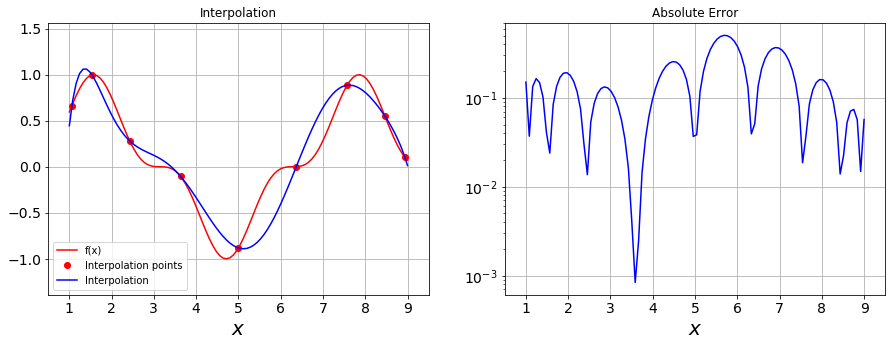

Max error (equidistants points): 1.98543531988
Max error (Chebyshev nodes): 0.503210144602


In [17]:
n=9
xmin=1
xmax=9

mee = Error(lambda x: np.sin(x)**3, n, xmin, xmax, method=Lagrange)
mec = Error(lambda x: np.sin(x)**3, n, xmin, xmax, method=Lagrange, points=Chebyshev_points)

print("Max error (equidistants points):", mee)
print("Max error (Chebyshev nodes):", mec)

In [18]:
def test_error_chebyshev(n):
    mee = Error(lambda x: (1/(1+12*x**2)), n, -1, 1, Lagrange)
    mec = Error(lambda x: (1/(1+12*x**2)), n, -1, 1, method=Lagrange, points=Chebyshev_points)
    print("Max error (equidistants points):", mee)
    print("Max error (Chebyshev nodes):", mec)

In [19]:
interact(test_error_chebyshev,n=(5,25))

interactive(children=(IntSlider(value=15, description='n', max=25, min=5), Output()), _dom_classes=('widget-in…

<function __main__.test_error_chebyshev>

Questions about Chebyshev:
- How can you calculate the Chebyshev points in the interval [a,b] instead of [-1,1]? **A: Using a change of variable**

## Convergence analysis 

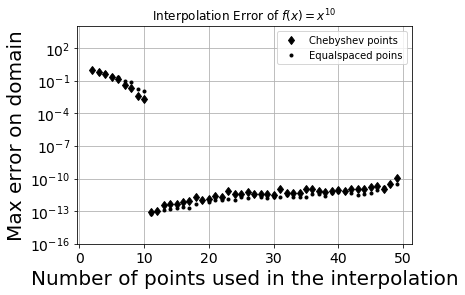

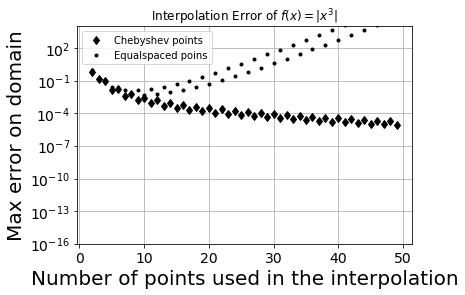

/Users/lukaszamora/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


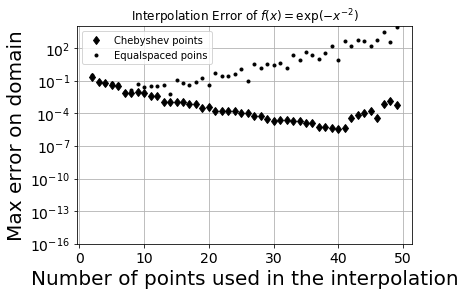

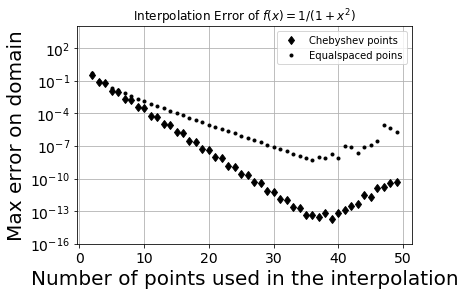

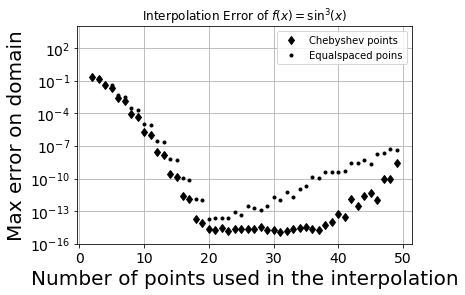

In [20]:
n=50
shift=2

my_functions={0:lambda x: (x)**10,
              1:lambda x: np.abs((x)**3),
              2:lambda x: np.exp(-((x)**-2)),
              3:lambda x: 1/(1+x**2),
              4:lambda x: np.sin(x)**3}
labels = {0: "x^{10}",
          1: "|x^3|",
          2: "\exp(-x^{-2})",
          3: "1/(1+x^2)",
          4: "\sin^3(x)"}

n_points=np.arange(shift,n)

for k in np.arange(5):
    max_error=np.zeros(n-shift)
    max_error_es=np.zeros(n-shift)
    for i in n_points:
        max_error[i-shift] = Error(my_functions[k], i, -1, 1, Newton, Chebyshev_points, plot_flag=False)
        max_error_es[i-shift] = Error(my_functions[k], i, -1, 1, Newton, points=np.linspace, plot_flag=False)
    axis=plt.figure()
    plt.semilogy(n_points,max_error,'kd',label='Chebyshev points')
    plt.semilogy(n_points,max_error_es,'k.',label='Equalspaced poins')
    plt.ylim(10**-16,10**4)
    plt.grid(True)
    plt.title('Interpolation Error of $f(x)='+str(labels[k])+"$")
    plt.xlabel('Number of points used in the interpolation')
    plt.ylabel('Max error on domain')
    plt.legend(loc='best')
    plt.show()

<div id='py' />
## Python Modules and Functions

Interpolation: 

http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html

Vandermonde Matrix: 

http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.vander.html

Lagrange: 

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.lagrange.html

Chebyshev Points:

http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.polynomial.chebyshev.chebroots.html#numpy.polynomial.chebyshev.chebroots

<div id='acknowledgements' />
# Acknowledgements
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. April 2016._
* _Material modified by Cristopher Arenas. May 2017._
* _Material modified by Claudio Torres. May 2017._
* _Bug fixed by Cristobal Carmona. April 2018._